# User's Guide, Chapter 30: Examples 3

Since the last set of examples in :ref:`Chapter 20 <usersGuide_20_examples2>`, we've learned about sorting streams, graphs and plots, Roman numerals, environment, post-tonal tools, iterators, grace notes, and spanners. Now let's put as many of these together as we can to analyze music computationally.

The corpus of `music21` includes the over 1050 songs, reels, and jigs from _Ryan's Mammoth Collection of Fiddle Tunes,_ thanks to [John Chambers](http://trillian.mit.edu/~jc/homepage.html) and others. The collection was originally published in 1883 by Blake Howe after William Bradbury Ryan's work. Let's use these, which are called "ryansMammoth" in the corpus, for some examples.

(Note that some of the tunes in this corpus are based on uncredited tunes either by African-American composers or adapted from such tunes ["Minstrel Songs"], and for these reasons were attacked in *Dwight's Journal* as too "trashy" (1855, p. 118) for cosmopolitan New England tastes.  The work of finding the 19th-century Black compositional geniuses behind the original tunes continues, and I hope we can supplement the adapated melodies in the corpus with originals in the near future.  In the meantime, I hope that the computational studies of these works can stick a finger in the face of John Sullivan Dwight, if his myopic vision of American creativity could ever see it.)

First we'll load `music21` and search the corpus for these tunes:

In [1]:
from music21 import *
ryans = corpus.search('ryansMammoth')
ryans

<music21.metadata.bundles.MetadataBundle {1059 entries}>

Let's look at one of these that I know is called 'Highland Regiment':

In [2]:
highland = ryans.search('Highland Regiment')
highland

<music21.metadata.bundles.MetadataBundle {1 entry}>

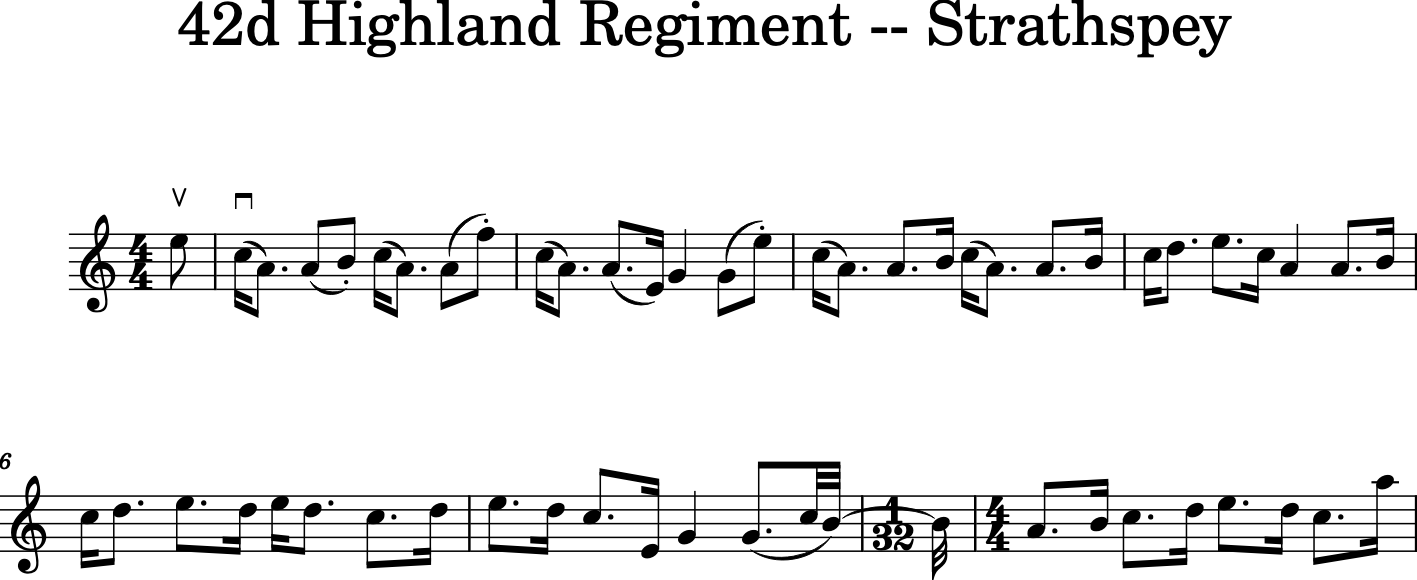

In [3]:
highlandParsed = highland[0].parse()
highlandParsed.measures(0, 8).show()

Let's take our knowledge of spanners and see if the last note of a slur is generally higher or lower than the first note.  We'll use a `RecursiveIterator` with a `ClassFilter` of 'Slur' to find them all:

In [4]:
highlandIterator = highlandParsed.recurse()
highlandSlurs = highlandIterator.getElementsByClass('Slur')

higher = 0
lower = 0
same = 0 # could happen for slurs longer than 2 notes

for sl in highlandSlurs:
    firstNote = sl.getFirst()
    lastNote = sl.getLast()
    psDiff = lastNote.pitch.ps - firstNote.pitch.ps
    if psDiff > 0:
        higher += 1
    elif psDiff < 0:
        lower += 1
    else:
        same += 1

In [5]:
(higher, lower, same)

(19, 30, 0)

Hmmm... it looks like of the 49 slurs in this piece, more of them end lower than higher.  Let's do this on a sample of the first 20 pieces in the collection.  Let's augment our slur counting function a little bit, and make it safe in case a slur begins on a Chord, by taking the average pitch value of all the notes in the Chord, introduce a Counter object from Python's `collections` module, and go to it:

In [7]:
from statistics import mean
from collections import Counter

totalCounter = Counter()

def countOneSlur(sl, totalCounter):
    firstNote = sl.getFirst()
    lastNote = sl.getLast()
    if not hasattr(firstNote, 'pitches'):
        return
    if not hasattr(lastNote, 'pitches'):
        return

    firstNotePs = mean(p.ps for p in firstNote.pitches)
    lastNotePs = mean(p.ps for p in lastNote.pitches)
    psDiff = lastNotePs - firstNotePs
    if psDiff > 0:
        totalCounter['higher'] += 1
    elif psDiff < 0:
        totalCounter['lower'] += 1
    else:
        totalCounter['same'] += 1

Now let's make a function that takes in an object from `corpus.search` and parses it and runs each slur through `countOneSlur`.

In [8]:
def runOneScore(scCorpusSearchObject, totalCounter):
    scParsed = scCorpusSearchObject.parse()
    for sl in scParsed.recurse().getElementsByClass('Slur'):
        countOneSlur(sl, totalCounter)


Always important to test to make sure we haven't broken anything.  This should give the same answer as before:

In [9]:
runOneScore(highland[0], totalCounter)

In [10]:
totalCounter

Counter({'lower': 30, 'higher': 19})

It works as before, though there's no "same" entry in `totalCounter` since we did not encounter such a case.  Let's reset our counter and run the first 20 pieces through the process:

In [11]:
totalCounter = Counter()

stop = 20
for piece in ryans:
    runOneScore(piece, totalCounter)
    stop = stop - 1
    if stop == 0:
        break


In [12]:
totalCounter

Counter({'lower': 90, 'higher': 80, 'same': 11})

Hmmm... this still shows a few more "lower" cases than "higher" but not very much of a difference.  In fact, the entire difference of 10 can be attributed to the first test example, since "Highland Regiment" is in this test set.  Maybe the notion that slurs more often end on lower notes than higher notes can be rejected, but I think we'd like to run the whole data set first.  Simply remove the "stop" and "break" variables from above and the results will come back in a minute or two.  I ran it and got these results:

    Counter({'higher': 3321, 'lower': 3637, 'same': 425})
    
Again, it's about 10% more times that a slur ends below the first note than above -- that's the same ratio as we saw for the first ten pieces, but it might be quite statistically significant given the much larger dataset.  After all, if you flip a coin three times, it's not that unusual to get all heads or all tails, but if you flip a coin one thousand times, even 550 heads and 450 tails is quite significant as an indicator of bias in the coin.  

So let's write a little test program that treats `'higher'` and `'lower'` as if they are coin flips and see how often we get results outside the range (in either direction) as our counter results.  `numBiased` takes in a `Counter` object, and a number of trials to run, flips a coin as many times as the higher and lower values and prints out the fraction of the flip trials that lie outside the range.  Optionally, it can print out the exceptional results along the way:

In [13]:
import random

def numBiased(inCounter, trials=100, printData=False):
    chanceTrials = 0
    totalSimulations = inCounter['higher'] + inCounter['lower']
    maxValue = max([inCounter['higher'], inCounter['lower']])
    minValue = min([inCounter['higher'], inCounter['lower']])
    for _trialNum in range(trials):
        randCounter = Counter()
        for _flipNum in range(totalSimulations):
            if random.randint(0, 1) == 1:
                outcome = 'higher'
            else:
                outcome = 'lower'
            randCounter[outcome] += 1
        if (randCounter['higher'] < maxValue
                and randCounter['higher'] > minValue):
            chanceTrials += 1
        elif printData:
            print(randCounter)
    return chanceTrials / trials

We'll run it first on the data from "Highland Regiment", printing out the intermediate values along the way:

In [14]:
numBiased(Counter({'higher': 19, 'lower': 30}), printData=True)

Counter({'higher': 30, 'lower': 19})
Counter({'higher': 31, 'lower': 18})
Counter({'higher': 31, 'lower': 18})
Counter({'lower': 32, 'higher': 17})
Counter({'lower': 30, 'higher': 19})
Counter({'lower': 30, 'higher': 19})
Counter({'lower': 31, 'higher': 18})
Counter({'lower': 31, 'higher': 18})
Counter({'lower': 30, 'higher': 19})
Counter({'higher': 30, 'lower': 19})
Counter({'lower': 30, 'higher': 19})
Counter({'higher': 30, 'lower': 19})
Counter({'higher': 31, 'lower': 18})
Counter({'lower': 31, 'higher': 18})
Counter({'lower': 31, 'higher': 18})


0.85

Most of the time, the results are within the range of Highland Regiment, but this is below the 0.95 threshold that would allow us to say that there's something happening here.  The results for the first ten pieces are even closer to a null hypothesis:

In [14]:
numBiased(Counter({'higher': 80, 'lower': 90, 'same': 11}))

0.46

But, as I noted above, much larger trials may be much more significant.  We will run it on the `Counter` object for the whole piece and see what the results are:

In [15]:
totalCounter = Counter({'higher': 3321, 'lower': 3637, 'same': 425})
numBiased(totalCounter)

1.0

Those are very significant results! There wasn't a single case where coins were flipped about 7000 times and we got fewer than 3321 or more than 3637 heads or tails! Thus we can definitely say that in this collection of fiddle tunes, you're more likely to slur down than up -- the size of the results is small, but the significance is high.

## Roman Numeral Analysis on a Melody

The majority of the pieces in _Ryan's Mammoth Collection_ are single-voice pieces, which might make Roman Numeral analysis difficult, but actually it can be even more interesting this way.  Let's take a tune from close to MIT's home, a reel called "The Boston":

In [16]:
bostonMD = ryans.search('The Boston -- Reel')
bostonMD

<music21.metadata.bundles.MetadataBundle {1 entry}>

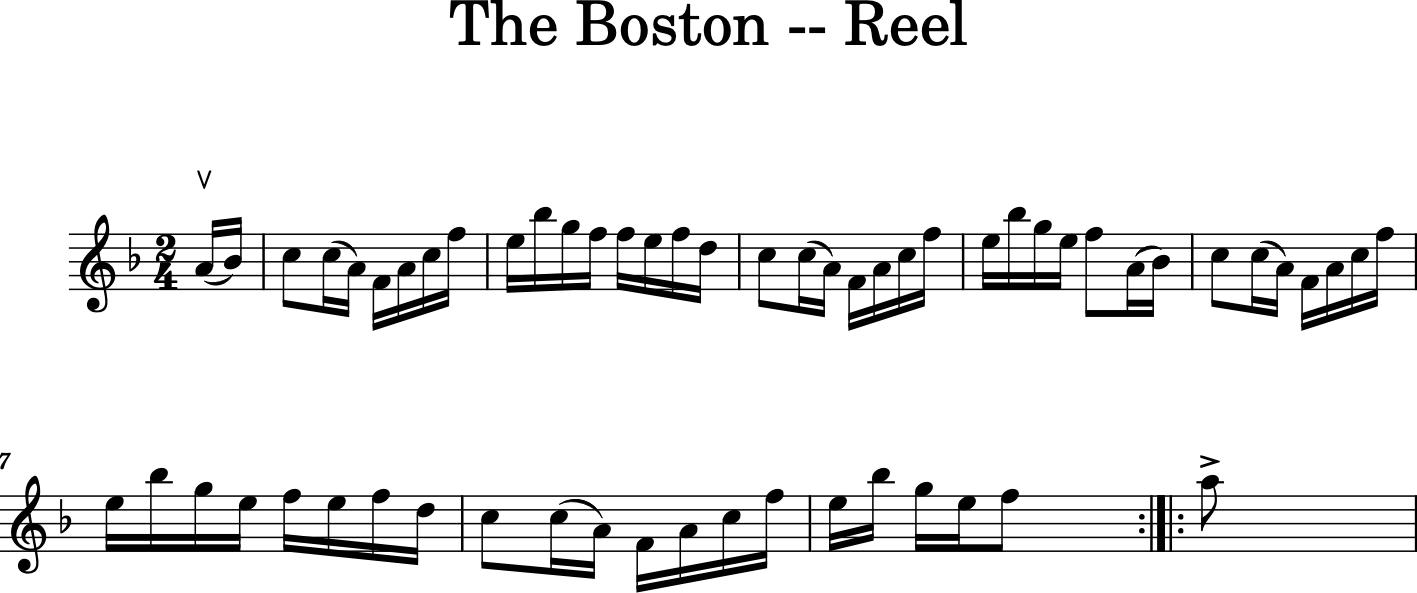

In [17]:
boston = bostonMD[0].parse()
boston.measures(0, 9).show()

Now let's create a chord from each beat in the piece (skipping the pickup notes), aggregating all the pitches from within that beat.  First, we'll create a new `Part` object that has the same framework of `Measures` as the original, along with time signatures, etc., but no notes.  We'll use the `.template()` method but tell it not to fill it with rests.

In [18]:
bostonPart = boston.parts[0]
outPart = bostonPart.template(fillWithRests=False)

Like we've done before, we'll start from the smallest part and work outwards.  Since we will be working with RomanNumerals, we'll have to know what key we are in; so we can analyze the piece; hopefully this will be F major.

In [19]:
pieceKey = boston.analyze('key')
pieceKey

<music21.key.Key of F major>

Now let's make a routine that turns a list of Notes into a RomanNumeral object:

In [20]:
def notesToRoman(notes):
    uniquePitches = set(n.pitch for n in notes)
    ch = chord.Chord(list(uniquePitches))
    return roman.romanNumeralFromChord(ch, pieceKey)

Let's test it with the notes of measure 1:

In [21]:
noteIterator = bostonPart.measure(1).notes
rn1 = notesToRoman(noteIterator)
rn1

<music21.roman.RomanNumeral I in F major>

Great, this is exactly what we're looking for.  Now let's go into each measure that is full and analyze it separately.

Now we'll go into each measure that is full, and analyze it separately.  We'll get everything from offset 0 to 1, then 1 to 2:

In [22]:
inMeasures = list(bostonPart[stream.Measure])
outMeasures = list(outPart[stream.Measure])

for i in range(14):
    inMeasure = inMeasures[i]
    if inMeasure.duration.quarterLength != 2.0:
        continue
    outMeasure = outMeasures[i]

    for beatStart in (0, 1):
        beatNotes = inMeasure.getElementsByOffset(beatStart,
                                                  beatStart + 1,
                                                  includeEndBoundary=False
                                                 ).getElementsByClass(note.NotRest)
        beatRN = notesToRoman(beatNotes)
        beatRN.lyric = beatRN.figure
        outMeasure.insert(beatStart, beatRN)

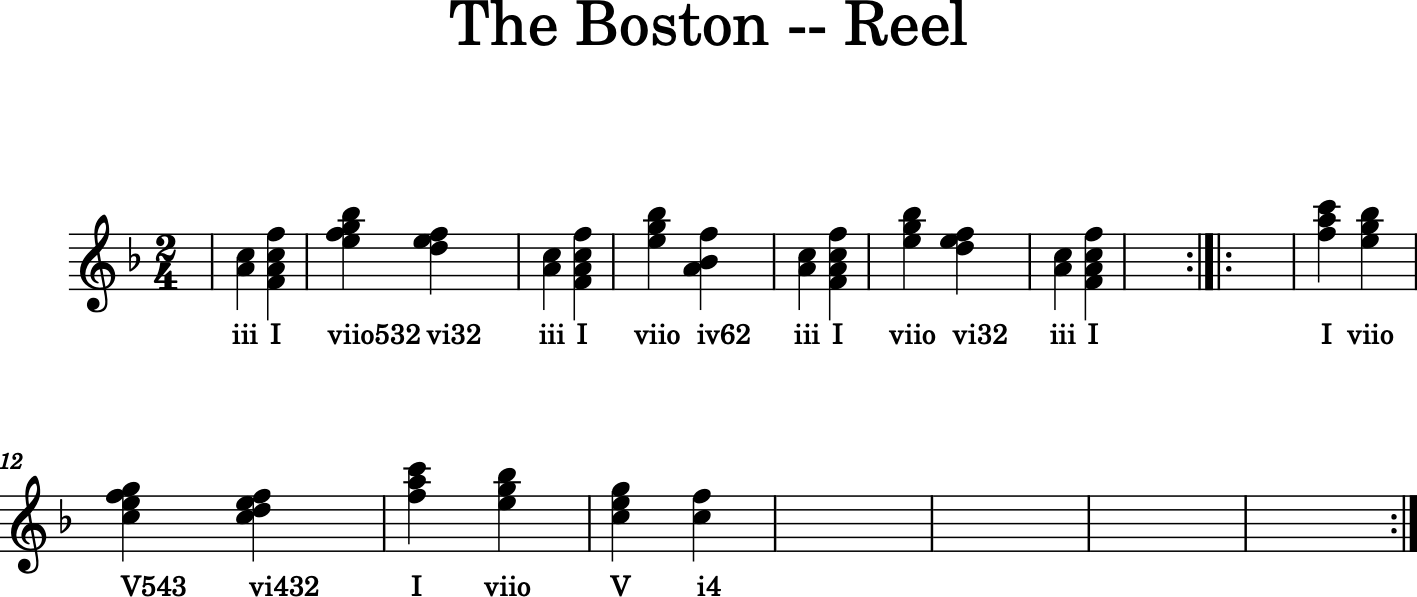

In [23]:
outPart.show()

Well, that's a great way to earn a C-minus in any music analysis class!  Yes, all of these chords are correct, but only a few are useful for analysis.  So let's do two things: (1) filter out all notes that are on a very weak position (the second or fourth sixteenth note) and are a passing or neighbor tone or something like that, and (2) not show the figure for anything with the functionality of a "iii" chord or less. First let's redefine `notesToRoman` to do just that.

In [24]:
def notesToRoman(notes):
    goodPitches = set()
    for n in notes:
        if (n.offset * 2) == int(n.offset * 2):
            goodPitches.add(n.pitch)
        else:
            nPrev = n.previous('Note')
            nNext = n.next('Note')
            if nPrev is None or nNext is None:
                continue
            prevInterval = interval.Interval(n, nPrev)
            nextInterval = interval.Interval(n, nNext)

            if (prevInterval.generic.undirected in (1, 2)
                and nextInterval.generic.undirected in (1, 2)):
                pass
            else:
                goodPitches.add(n.pitch)
    ch = chord.Chord(list(goodPitches))
    return roman.romanNumeralFromChord(ch, pieceKey)

Now we can figure out that `functionalityScore` minimum:

In [25]:
iii = roman.RomanNumeral('iii')
iii.functionalityScore

15

And let's re-run it:

In [26]:
outPart = bostonPart.template(fillWithRests=False)

inMeasures = list(bostonPart[stream.Measure])
outMeasures = list(outPart[stream.Measure])

for i in range(14):
    inMeasure = inMeasures[i]
    if inMeasure.duration.quarterLength != 2.0:
        continue
    outMeasure = outMeasures[i]

    for beatStart in (0, 1):
        beatNotes = inMeasure.getElementsByOffset(beatStart,
                                                  beatStart + 1,
                                                  includeEndBoundary=False
                                                 ).getElementsByClass(note.NotRest)
        beatRN = notesToRoman(beatNotes)
        if beatRN.functionalityScore > 15:
            beatRN.lyric = beatRN.figure
        outMeasure.insert(beatStart, beatRN)

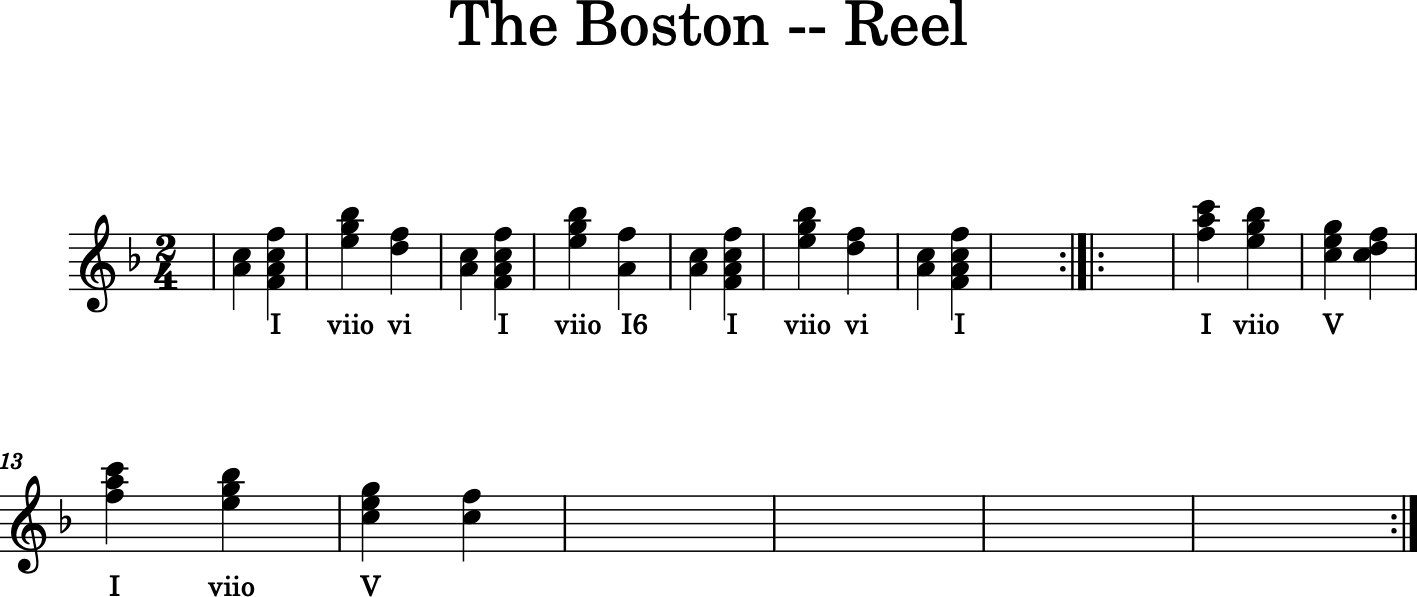

In [27]:
outPart.show()

It's still not great, but we get a much better sense from this that the diminished chord on vii in root position is often being used in place of V as a dominant in this piece.  Let's run the routine one more time and this time put the lyrics directly back in the score:

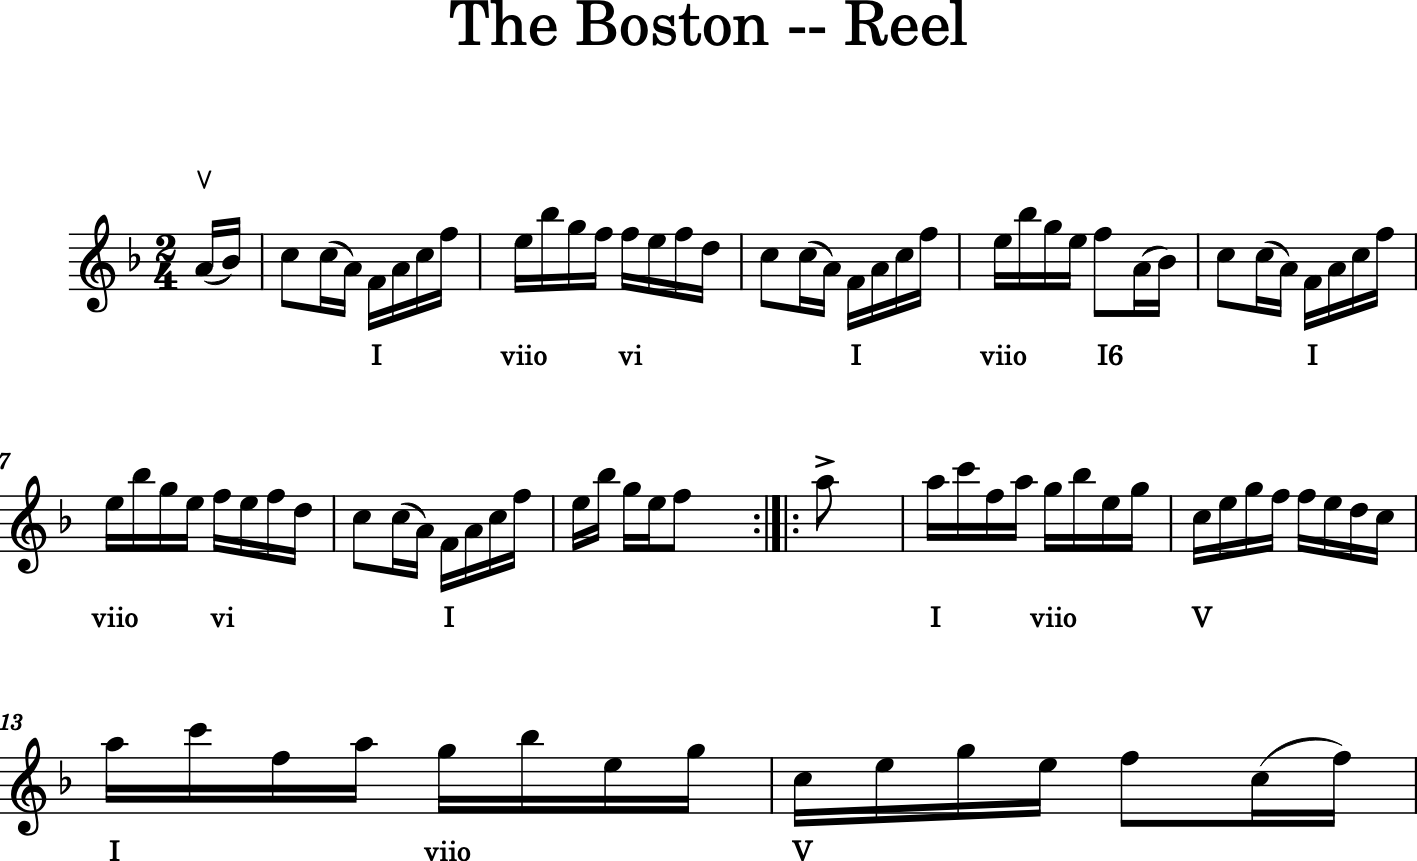

In [28]:
inMeasures = list(bostonPart[stream.Measure])

for i in range(14):
    inMeasure = inMeasures[i]
    if inMeasure.duration.quarterLength != 2.0:
        continue

    for beatStart in (0, 1):
        beatNotes = inMeasure.getElementsByOffset(beatStart,
                                                  beatStart + 1,
                                                  includeEndBoundary=False
                                                 ).getElementsByClass(note.NotRest)
        beatRN = notesToRoman(beatNotes)
        if beatRN.functionalityScore > 15:
            beatNotes[0].lyric = beatRN.figure

bostonPart.measures(0, 13).show()

This is looking pretty decent, but have no fears, we'll find more sophisticated score reduction tools in `music21` in the chapters to come.

Let's visualize this whole piece as a piano roll:

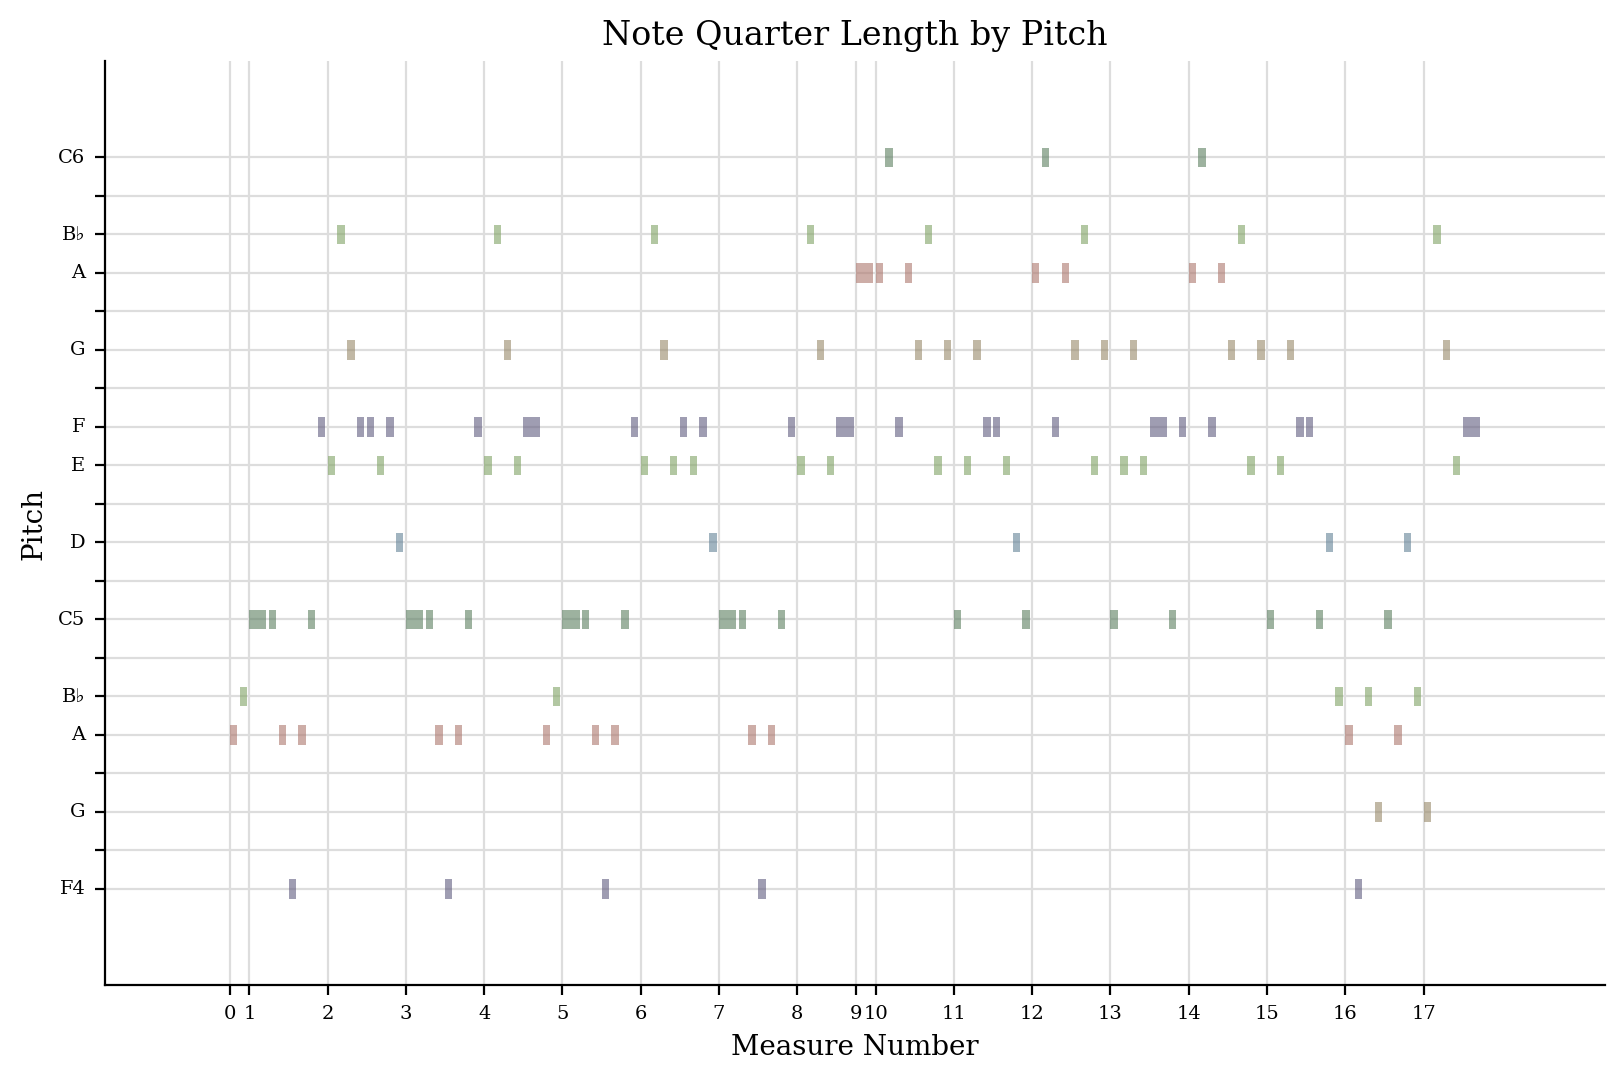

In [29]:
bostonPart.plot('pianoroll')

Here the centrality of the low F and the C5 stand out, along with an avoidance of the low tonic during the middle section, from measures 10-15, which I presume emphasizes the dominant harmony, but due to the presence of B-flats, is not _in_ the dominant.

In [30]:
bostonPart.measures(10, 15).analyze('key')

<music21.key.Key of F major>

It's clear that this piece is not chromatic at all, as a histogram of the pitch classes will show well:

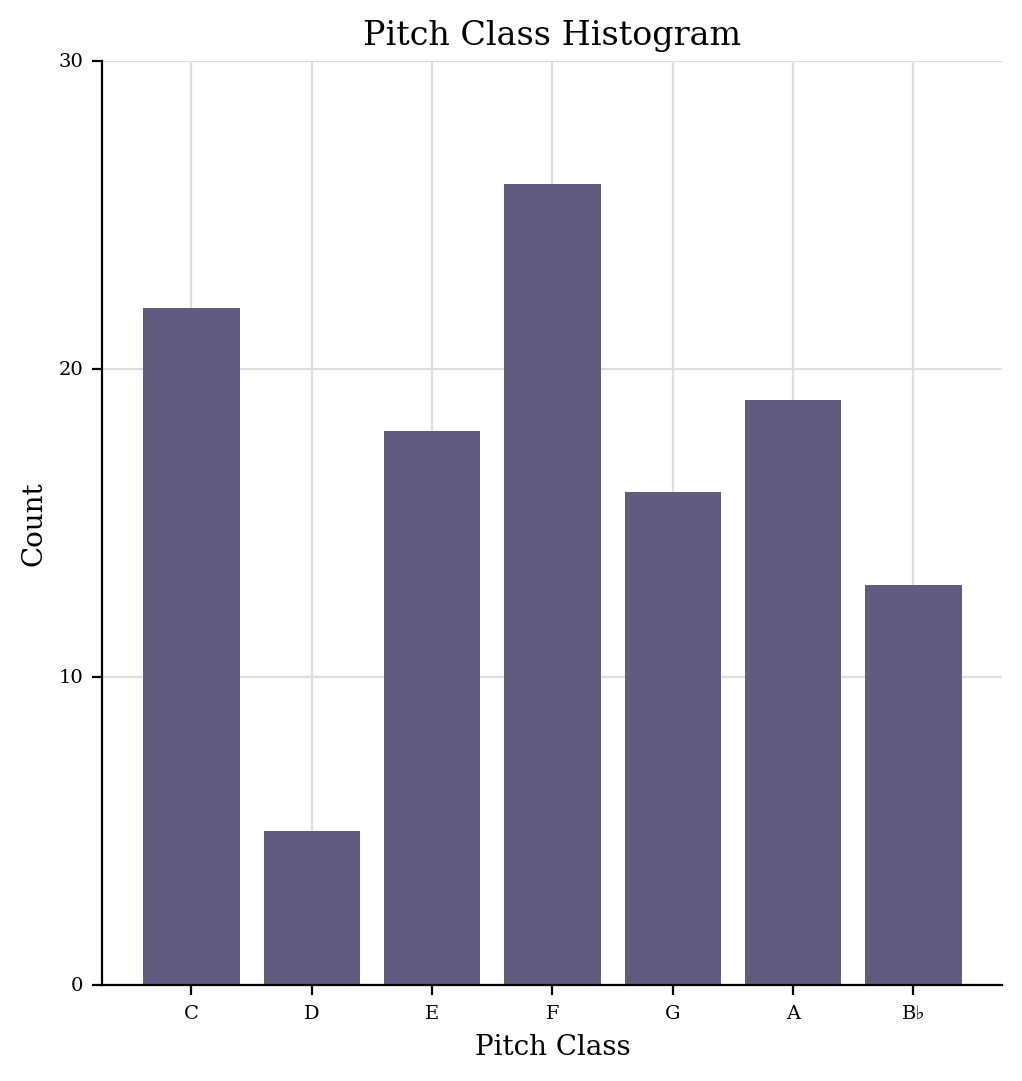

In [31]:
bostonPart.plot('histogram', 'pitchClass')

Are there particular pitches -- perhaps exploiting the open strings -- that appear more often in this repertory?  We can stitch a bunch of pieces together and see.  We'll use an `Opus` Stream, which is a Stream that can hold other scores:

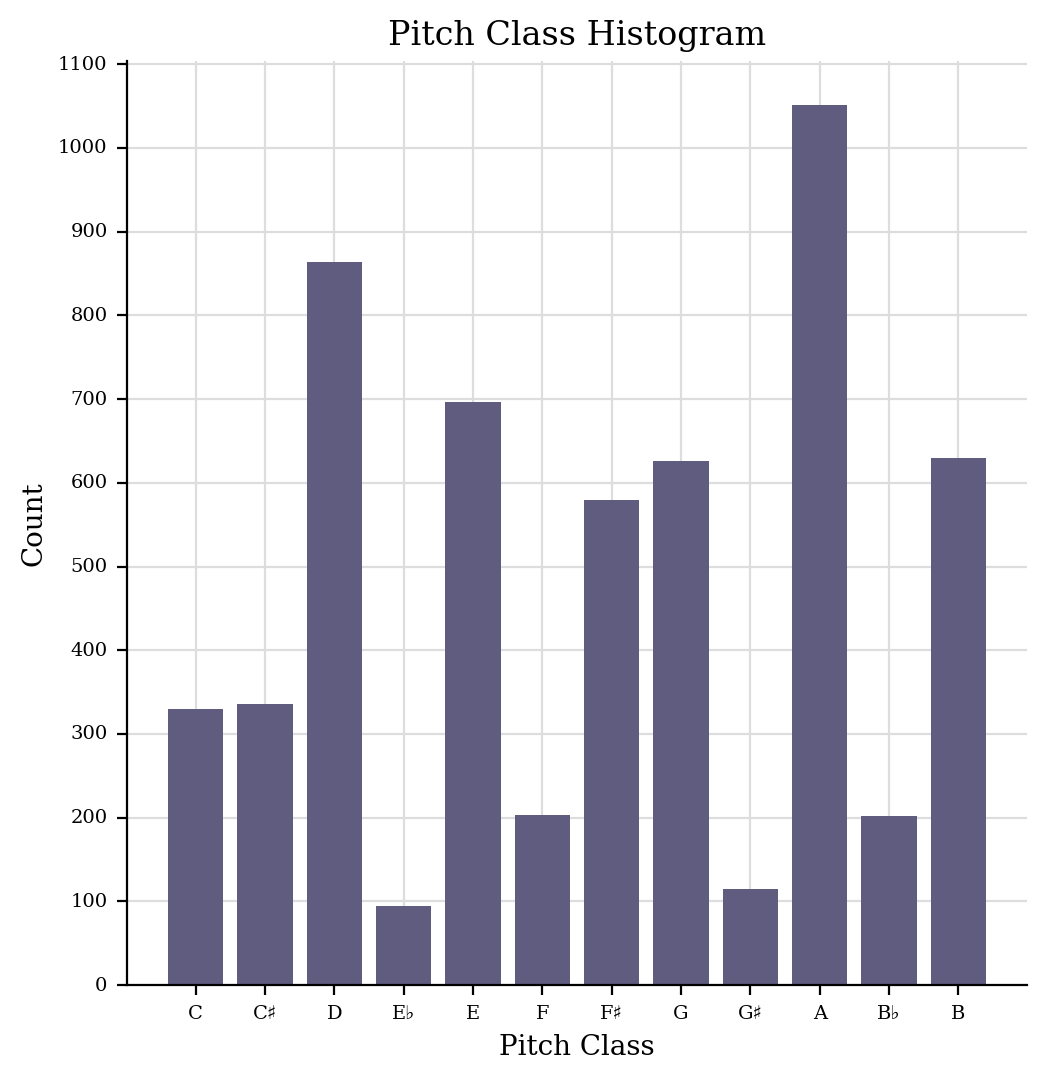

In [32]:
manyScores = stream.Opus()

for i in range(50):
    sc = ryans[i].parse()
    manyScores.insert(0, sc)

manyScores.plot('histogram', 'pitchClass')

It appears Boston Reel was "wicked queer" for using F major.  Many more pieces emphasize notes of the open strings on the violin, with A, D, and E being the top three most used pitches (with G about tied with B).

Well, we didn't get to everything since the last set of examples, but we got through a lot, and I hope it gives some sense of what you could do with your own repertory.  Let's now dial back the difficulty for the next section and look at some fundamental objects we've missed in :ref:`Chapter 31: Clefs, Ties, and Beams <usersGuide_31_clefs>`.